# Neural Learning
* Spike Timing Dependent Plasticity (STDP)
* Reward Based Spike Timing Dependent Plasticity (RSTDP)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from copy import deepcopy
import heapq

# Neuron Class
* LIF model is used

In [2]:
class LIF:
    def __init__(self, R, tau, u_rest, threshold, u_spike, u_reset):
        self.history = []
        self.spikes = []
        self.current = []
        self.R = R
        self.tau = tau
        self.u = u_rest
        self.u_rest = u_rest
        self.threshold = threshold
        self.u_spike = u_spike
        self.u_reset = u_reset

    def process(self, current_function, timespan, dt, reset=True):
        if reset:
            self.to_rest()
        size = math.ceil(timespan / dt)
        U = np.zeros(shape=(size, 2))
        spikes = []
        time = 0
        for index in range(len(U)):
            U[index, 1] = self.u
            U[index, 0] = time
            if self.u > self.threshold:
                spikes.append(time)
                self.reset()
            du = dt * (-1 * (self.u - self.u_rest) + 1e-3 * self.R * current_function(time)) / self.tau
            self.u += du
            time += dt
        return {'voltage': U, 'spikes': spikes}

    def frequency(self, current_range, timespan, dt):
        data = np.zeros(shape=(len(current_range), 2))
        for index in range(len(current_range)):
            self.to_rest()
            Func = lambda x: current_range[index]
            result = self.process(Func, timespan=timespan, dt=dt)
            result = result['spikes']
            data[index, 0] = current_range[index]
            if len(result) == 0:
                data[index, 1] = 0
            elif len(result) == 1:
                data[index, 1] = 1 / timespan
            else:
                data[index, 1] = (len(result) - 1) / (result[-1] - result[0])
        return data

    def single_step(self, input_current, time, dt):
        du = dt * (-1 * (self.u - self.u_rest) + 1e-3 * self.R * input_current) / self.tau
        self.u += du
        time += dt
        self.history.append((self.u, time))
        self.current.append((input_current, time))
        if self.u > self.threshold:
                self.spikes.append(time)
                self.reset()

    def reset(self):
        self.u = self.u_reset
    
    def to_rest(self):
        self.u = self.u_rest

    def clear_history(self):
        self.history = []
        self.spikes = []
        self.current = []
        self.u = self.u_rest

# Population

In [3]:
class Population:
    def __init__(self, population_type, neuron_list, time_course, j=20):
        self.population_activity = []
        self.neuron_list = neuron_list
        self.connections = np.zeros((len(neuron_list), len(neuron_list)))
        self.j = j
        self.connection_type = self.fully_connection
        set_connection = self.connection_type
        self.population_type = population_type
        set_connection()
        self.time_course = time_course
        self.connection_history = deepcopy(self.connections.ravel())
    
    def fully_connection(self):
        self.connections = np.ones_like(self.connections) * (self.j / len(self.neuron_list))
        self.inhibitory_coeff_mannager()

    def calculate_activity_history(self, time, dt, threshold):
        activity_list = np.zeros((len(self.neuron_list), 1))
        for idx in range(len(self.neuron_list)):
            activity_list[idx, 0] = self.calculate_activity_history_single(idx, time, dt, threshold)
        return activity_list

    def calculate_activity_history_single(self, idx, time, dt, threshold):
        neuron = self.neuron_list[idx]
        S = 0
        activity = 0
        while self.time_course(S) > threshold:
            if (time - S) in neuron.spikes:
                activity += self.time_course(S)
            S += dt
        return activity

    def single_step(self, input_current, self_activity, time, dt, time_course_threshold):
        inputs = self.connections.dot(self_activity)
        for i, neuron in enumerate(self.neuron_list):
            neuron.single_step(input_current + inputs[i, 0], time, dt)
        activity = self.calculate_activity_history(time + dt, dt, time_course_threshold)
        return activity

    def reset(self, reset_connection=False):
        self.population_activity = []
        if reset_connection:
            set_connection = self.connection_type
            set_connection()
        for neuron in self.neuron_list:
            neuron.clear_history()

    def inhibitory_coeff_mannager(self):
        if self.population_type == 'inhibitory':
            self.connections = -1 * self.connections

    
    def raster_plot_data(self):
        x = []
        y = []
        for neuron in self.neuron_list:
            id = '#' + str(int(np.floor(np.random.rand() * 10000000)))
            for l in neuron.spikes:
                x.append(l)
                y.append(id)
        return x, y
    

    def run_and_learn(self, input_current_list, time_interval, dt, 
                      dt_minus, dt_plus, a_minus, a_plus, time_course_threshold):
        learn = self.STDP
        time = 0
        activity = np.zeros((len(self.neuron_list), 1))
        while time <= time_interval:
            inputs = self.connections.dot(activity)
            for i, neuron in enumerate(self.neuron_list):
                neuron.single_step(input_current_list[i](time) + inputs[i, 0], time, dt)
            activity = self.calculate_activity_history(time + dt, dt, time_course_threshold)
            learn(time + dt, dt_minus, dt_plus, a_minus, a_plus)
            time += dt

    def STDP(self, time, dt_minus, dt_plus, a_minus, a_plus):
        new_connections = deepcopy(self.connections)
        for i in range(len(self.neuron_list)):
            for j in range(len(self.neuron_list)):
                if i != j:
                    pre_neuron = self.neuron_list[j]
                    post_neuron = self.neuron_list[i]
                    if len(pre_neuron.spikes) != 0 and len(post_neuron.spikes) != 0 and \
                    post_neuron.spikes[len(post_neuron.spikes) - 1] == time:
                        if post_neuron.spikes[len(post_neuron.spikes) - 1] > pre_neuron.spikes[len(pre_neuron.spikes) - 1]:
                            dt = abs(post_neuron.spikes[len(post_neuron.spikes) - 1] - 
                                     pre_neuron.spikes[len(pre_neuron.spikes) - 1])
                            new_connections[i, j] += a_plus * math.exp(-(dt / dt_plus))
                    if len(pre_neuron.spikes) != 0 and len(post_neuron.spikes) != 0 and \
                    pre_neuron.spikes[len(pre_neuron.spikes) - 1] == time:
                        if post_neuron.spikes[len(post_neuron.spikes) - 1] < pre_neuron.spikes[len(pre_neuron.spikes) - 1]:
                            dt = abs(post_neuron.spikes[len(post_neuron.spikes) - 1] -
                                     pre_neuron.spikes[len(pre_neuron.spikes) - 1])
                            new_connections[i, j] += a_minus * math.exp(-(dt / dt_minus))
                            if new_connections[i, j] < 0:
                                new_connections[i, j] = 0
        self.connection_history=np.vstack((self.connection_history,new_connections.ravel()))
        self.connections=deepcopy(new_connections)

# Spiking Neural Network

In [4]:
class SNN:
    def __init__(self, network_dim, lif_neuron_parameters, time_course, tau_tag, tau_dopamine, reward_score, j=8):
        self.network_dim = network_dim
        self.lif_neuron_parameters = lif_neuron_parameters
        self.connectivity = self.fully_connect
        self.network_neurons = []
        self.connections = []
        self.j = j
        self.tau_dopamine = tau_dopamine
        self.tau_tag = tau_tag
        self.tags = []
        self.reward_score = reward_score
        self.connection_history = []
        self.time_course = time_course
        self.create_network_neurons()
        self.connectivity()
        self.dopamine = 0

    def fully_connect(self):
        for i in range(1, len(self.network_dim)):
            self.connections.append(np.ones((self.network_dim[i - 1], self.network_dim[i])) *
                                    self.j + np.random.rand())
            self.connection_history.append(deepcopy(self.connections[-1].ravel()))
            self.tags.append(np.zeros((self.network_dim[i - 1], self.network_dim[i])))

    def create_network_neurons(self):
        for i in range(len(self.network_dim)):
            neuron_list = []
            for j in range(self.network_dim[i]):
                if self.lif_neuron_parameters['random']:
                    neuron_list.append(
                        LIF(
                            self.lif_neuron_parameters['R'] + np.random.rand() * 
                            self.lif_neuron_parameters['rand_change'],
                            self.lif_neuron_parameters['tau'] + np.random.rand() * 
                            self.lif_neuron_parameters['rand_change'],
                            self.lif_neuron_parameters['u_rest'] + np.random.rand() * 
                            self.lif_neuron_parameters['rand_change'],
                            self.lif_neuron_parameters['threshold'] + np.random.rand() * 
                            self.lif_neuron_parameters['rand_change'],
                            self.lif_neuron_parameters['u_spike'] + np.random.rand() * 
                            self.lif_neuron_parameters['rand_change'],
                            self.lif_neuron_parameters['u_reset'] + np.random.rand() * 
                            self.lif_neuron_parameters['rand_change']
                        )
                    )
                else:
                    neuron_list.append(
                        LIF(
                            self.lif_neuron_parameters['R'],
                            self.lif_neuron_parameters['tau'],
                            self.lif_neuron_parameters['u_rest'],
                            self.lif_neuron_parameters['threshold'],
                            self.lif_neuron_parameters['u_spike'],
                            self.lif_neuron_parameters['u_reset']
                        )
                    )
            self.network_neurons.append(deepcopy(neuron_list))

    def fit(self, x, y, dt, epoch_time, dt_minus, dt_plus, a_minus, a_plus, time_course_threshold, iterations, learn_time):
        time = 0
        lt = learn_time
        for iter in range(iterations):
            index = np.random.randint(low=0, high=x.shape[0])
            epoch = 0
            while epoch < epoch_time:
                inputs = x[index]
                for layer in range(len(self.network_neurons)):
                    for i, neuron in enumerate(self.network_neurons[layer]):
                        neuron.single_step(inputs[i], time, dt)
                    if layer != len(self.network_neurons) - 1:
                        activities = self.calculate_activity_history(layer, time + dt, dt,time_course_threshold)
                        inputs = activities@self.connections[layer]
                flag = False
                if time > lt:
                    flag = True
                    lt += learn_time
                self.learn(y, index, time + dt, dt, dt_minus, dt_plus, a_minus, a_plus, learn_time, flag)
                if flag:
                    flag = False
                epoch += dt
                time += dt

    def learn(self, y, index, time, dt, dt_minus, dt_plus, a_minus, a_plus, learn_time, flag):
        for layer in range(len(self.connections)):
            for i in range(len(self.network_neurons[layer])):
                for j in range(len(self.network_neurons[layer + 1])):
                    pre_neuron=self.network_neurons[layer][i]
                    post_neuron=self.network_neurons[layer][j]
                    stdp = 0
                    if len(pre_neuron.spikes) != 0 and len(post_neuron.spikes) != 0 and \
                    post_neuron.spikes[len(post_neuron.spikes) - 1] == time:
                        if post_neuron.spikes[len(post_neuron.spikes) - 1] > pre_neuron.spikes[len(pre_neuron.spikes) - 1]:
                            dt = abs(post_neuron.spikes[len(post_neuron.spikes) - 1] - 
                                     pre_neuron.spikes[len(pre_neuron.spikes) - 1])
                            stdp += a_plus * math.exp(-(dt / dt_plus))
                            
                    if len(pre_neuron.spikes) != 0 and len(post_neuron.spikes) != 0 and \
                    pre_neuron.spikes[len(pre_neuron.spikes) - 1] == time:
                        if post_neuron.spikes[len(post_neuron.spikes) - 1] < pre_neuron.spikes[len(pre_neuron.spikes) - 1]:
                            dt = abs(post_neuron.spikes[len(post_neuron.spikes) - 1] - 
                                     pre_neuron.spikes[len(pre_neuron.spikes) - 1])
                            stdp += a_minus * math.exp(-(dt / dt_minus))

                    self.tags[layer][i, j] += dt * ((-self.tags[layer][i, j] / self.tau_tag) + stdp)
                    self.connections[layer][i, j] += dt * (self.tags[layer][i, j] * self.dopamine)
                    if self.connections[layer][i, j] < 0:
                        self.connections[layer][i, j] = 0
        
        reward = 0
        if flag:
            actions = np.zeros_like(self.network_neurons[-1])
            for i, neuron in enumerate(self.network_neurons[-1]):
                amount = 0
                for spike in reversed(neuron.spikes):
                    if time - spike > learn_time:
                        amount += 1
                actions[i] = amount
            if np.argmax(actions) == int(y[index]):
                largest_integers = heapq.nlargest(2, list(actions))
                if largest_integers[0] != 0 and (largest_integers[0] - largest_integers[1])/largest_integers[0] > 0.1:
                    reward += self.reward_score
                else:
                    reward -= self.reward_score
            else :
                reward -= self.reward_score
        self.dopamine += learn_time * ((-self.dopamine / self.tau_dopamine) + reward)
        for i in range(len(self.connection_history)):
            self.connection_history[i] = np.vstack((self.connection_history[i], self.connections[i].ravel()))


    def calculate_activity_history(self, layer, time, dt, time_course_threshold):
        activity_list = np.zeros(self.network_dim[layer])
        for idx in range(self.network_dim[layer]):
            activity_list[idx] = self.calculate_activity_history_single(layer, idx, time, dt, time_course_threshold)
        return activity_list

    def calculate_activity_history_single(self, layer, index, time, dt, time_course_threshold):
        neuron = self.network_neurons[layer][index]
        S = 0
        activity = 0
        while self.time_course(S) > time_course_threshold:
            if (time - S) in neuron.spikes:
                activity += self.time_course(S)
            S += dt
        return activity 

    def predict(self, x, time_interval, dt, time_course_threshold):
        results = np.zeros((len(x)))
        for i in range(len(x)):
            self.reset()
            time = 0
            while time < time_interval:
                inputs = x[i]
                for layer in range(len(self.network_neurons)):
                    for k, neuron in enumerate(self.network_neurons[layer]):
                        neuron.single_step(inputs[k], time,dt)
                    if layer != len(self.network_neurons) - 1:
                        activities = self.calculate_activity_history(layer, time + dt, dt, time_course_threshold)
                        inputs = activities@self.connections[layer]
                time += dt
            end_layer = self.network_neurons[-1]
            end_layer_result = np.zeros((len(end_layer)))
            for j in range(len(end_layer_result)):
                end_layer_result[j] = len(end_layer[j].spikes)
            results[i] = np.argmax(end_layer_result)
        return results

    def reset(self):
        for i in range(len(self.network_neurons)):
            for neuron in self.network_neurons[i]:
                neuron.clear_history()
        pass

# Time Course Function
* for excitatory population

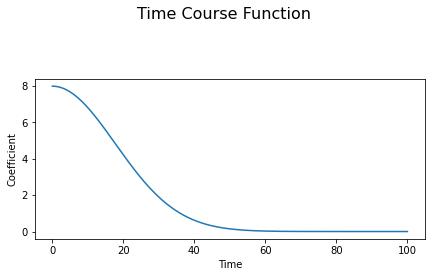

In [5]:
def ex_time_course(time, sigma=25, m=0):
    return 500 * (1 / (sigma * math.sqrt(2 * math.pi))) * math.exp(-((time - m) / sigma) ** 2)


# plotting
times = np.arange(0, 100, 0.01)
y = np.zeros_like(times)
for i, t in enumerate(times):
    y[i] = ex_time_course(t)
    
figure = plt.figure(figsize=(7, 10))
figure.suptitle('Time Course Function', fontsize=16)
res = figure.add_subplot(311)
res.plot(times, y)
res.set_ylabel("Coefficient")
res.set_xlabel("Time")
plt.show()

# STDP Learning With Three Neurons

In [7]:
class STDP:
    current1 = None
    current2 = None
    current3 = None
    timelist = []
    population = None
    def __init__(self, first_function: str, second_function: str, third_function: str):
        neuron_list = []
        population_size = 3
        seed = 42
        np.random.seed(seed)
        for i in range(population_size):
            neuron_list.append(LIF(10 + np.random.rand() * 3, 8 + np.random.rand() * 4, -79, -50, 5, -68))
        global population
        population = Population(population_type='exitatory',
                                    neuron_list=neuron_list,
                                    time_course=ex_time_course)
        
        global current1
        current1 = lambda x: eval(first_function)
        global current2
        current2 = lambda x: eval(second_function)
        global current3
        current3 = lambda x: eval(third_function)
        input_current_list = [current1, current2, current3]
        population.run_and_learn(input_current_list=input_current_list,
                                 time_interval=50,
                                 dt=0.03125,
                                 dt_minus=6,
                                 dt_plus=10,
                                 a_minus=-4,
                                 a_plus=+6,
                                 time_course_threshold=0.3)
        global timelist
        timelist = []
        time = 0
        dt = 0.03125
        for i in range(len(population.connection_history)):
            timelist.append(time)
            time += dt
            
    def input_plotting(self):
        figure = plt.figure(figsize=(15, 4))
        figure.suptitle('', fontsize=15)

        # neuron1
        ax1 = figure.add_subplot(131)
        current = []
        for i in timelist:
            current.append(current1(i))
        ax1.plot(timelist, current)
        ax1.set_ylabel("Input")
        ax1.set_xlabel("Time")
        ax1.set_title('Neuron 1')

        # neuron2
        ax1 = figure.add_subplot(132)
        current = []
        for i in timelist:
            current.append(current2(i))
        ax1.plot(timelist, current)
        ax1.set_ylabel("Input")
        ax1.set_xlabel("Time")
        ax1.set_title('Neuron 2')

        # neuron3
        ax1 = figure.add_subplot(133)
        current = []
        for i in timelist:
            current.append(current3(i))
        ax1.plot(timelist,current)
        ax1.set_ylabel("Input")
        ax1.set_xlabel("Time")
        ax1.set_title('Neuron 3')
        plt.show()
        
    def weight_plotting(self):
        figure = plt.figure(figsize=(15,10))
        figure.suptitle('Synaptic Weight Changes (STDP Rule)', fontsize=16)

        # w12
        ax1 = figure.add_subplot(231)
        ax1.plot(timelist, population.connection_history[:,1])
        ax1.set_ylabel("connetion weight")
        ax1.set_xlabel("Time")
        ax1.set_title('W12')

        # w13
        ax1 = figure.add_subplot(232)
        ax1.plot(timelist, population.connection_history[:,2])
        ax1.set_ylabel("connetion weight")
        ax1.set_xlabel("Time")
        ax1.set_title('W13')

        # w21
        ax1 = figure.add_subplot(233)
        ax1.plot(timelist, population.connection_history[:,3])
        ax1.set_ylabel("connetion weight")
        ax1.set_xlabel("Time")
        ax1.set_title('W21')

        # w23
        ax1 = figure.add_subplot(234)
        ax1.plot(timelist, population.connection_history[:,5])
        ax1.set_ylabel("connetion weight")
        ax1.set_xlabel("Time")
        ax1.set_title('W23')

        # w31
        ax1 = figure.add_subplot(235)
        ax1.plot(timelist, population.connection_history[:,6])
        ax1.set_ylabel("connetion weight")
        ax1.set_xlabel("Time")
        ax1.set_title('W31')

        # w32
        ax1 = figure.add_subplot(236)
        ax1.plot(timelist, population.connection_history[:,7])
        ax1.set_ylabel("connetion weight")
        ax1.set_xlabel("Time")
        ax1.set_title('W32')

        plt.show()

# First Input
* three diffenrent constant inputs

In [8]:
s = STDP("4000", "6500", "3000")

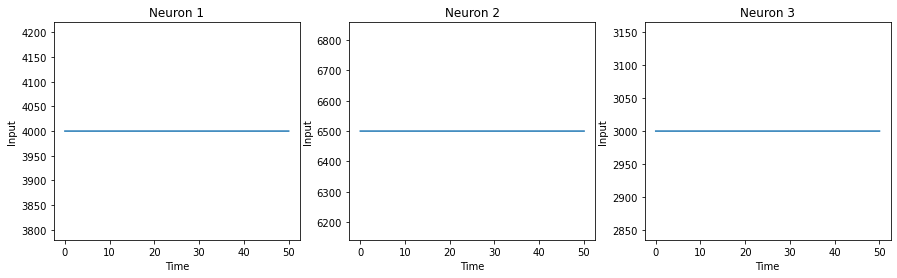

In [9]:
s.input_plotting()

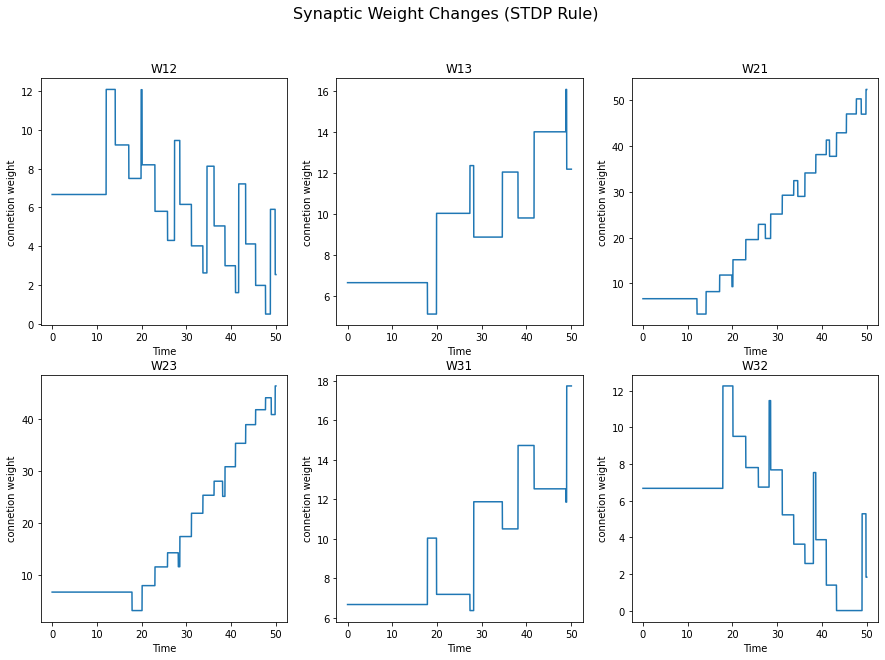

In [10]:
s.weight_plotting()

# Second Input
* two different constant inputs
* one sine input

In [11]:
s = STDP("3000", "4000", "5000 * (math.sin(x) + 0.9)")

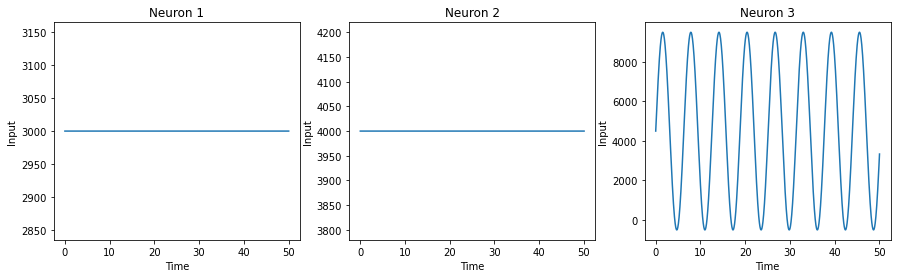

In [12]:
s.input_plotting()

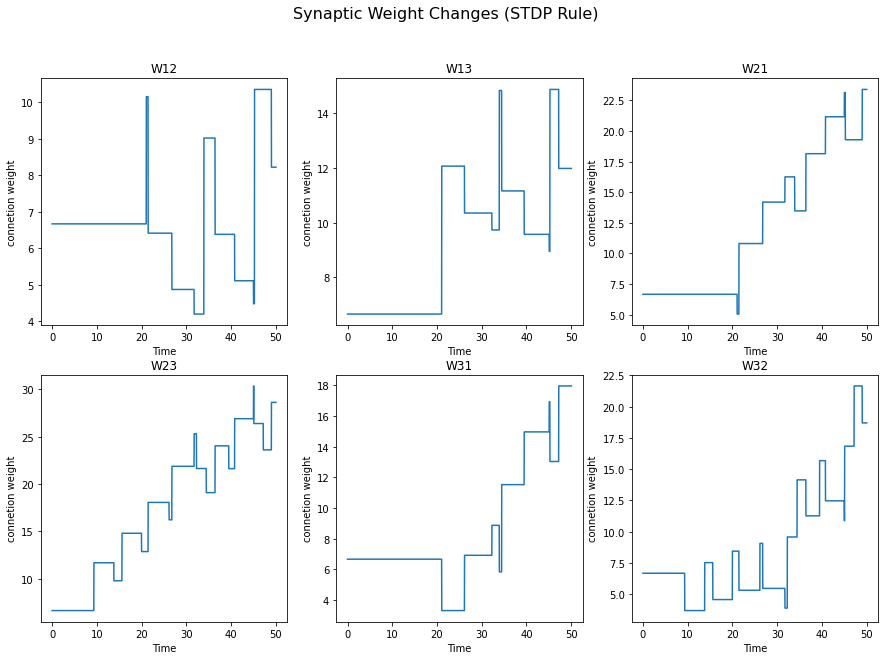

In [13]:
s.weight_plotting()

# Third Input
* one constant inputs
* one sine input
* one step input

In [14]:
s = STDP("4000", "5000 if 10 < x < 20 or 30 < x < 40 else 0", "4000 * (math.sin(x) + 0.9)")

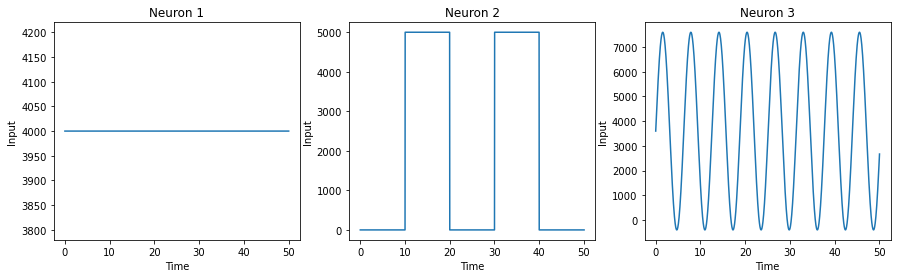

In [15]:
s.input_plotting()

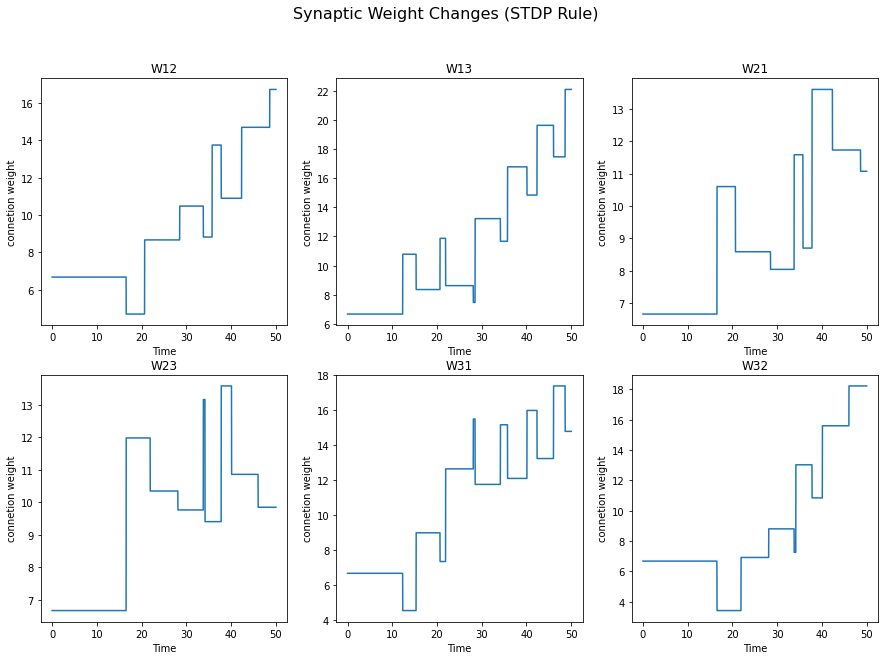

In [16]:
s.weight_plotting()

# Time Course Function For SNN

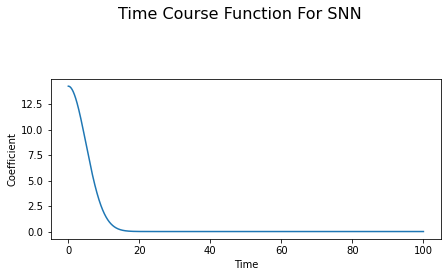

In [17]:
def snn_time_course(time, sigma=7, m=0):
    return 250 * (1 / (sigma * math.sqrt(2 * math.pi))) * math.exp(-((time - m) / sigma) ** 2)


# plotting
times = np.arange(0, 100, 0.01)
y = np.zeros_like(times)
for i, t in enumerate(times):
    y[i] = snn_time_course(t)
    
figure = plt.figure(figsize=(7, 10))
figure.suptitle('Time Course Function For SNN', fontsize=16)
res = figure.add_subplot(311)
res.plot(times,y)
res.set_ylabel("Coefficient")
res.set_xlabel("Time")
plt.show()

# Reward Based STDP Learning

# Read Dataset

In [18]:
dataset = pd.read_excel('./CN_3_DATASET.xlsx')
dataset

,test,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,inpput_neuron_number,train_1,train_2,train_3,train_4,train_5,train_6,train_7,train_8,train_9,train_10
1,1.0,1.0,2.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,2.0
2,2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0
3,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0
5,5.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,2.0
6,output_neuron_number,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,inpput_neuron_number,train_1,train_2,train_3,train_4,train_5,train_6,train_7,train_8,train_9,train_10


In [19]:
x_train = dataset.iloc[1:6,1:].values.T * 10000
y_train = dataset.iloc[6,1:].values
x_test = dataset.iloc[10:15,1:].values.T * 10000
y_test = dataset.iloc[15,1:].values

# Train Network

In [20]:
np.random.seed(42)
lif_neuron_parameters= \
{
    'R': 10,
    'tau': 8,
    'u_rest': -79,
    'threshold': -50,
    'u_spike': 5,
    'u_reset': -68,
    'random': True,
    'rand_change': 2
}

neural_network = SNN(network_dim=(5, 2),
                   lif_neuron_parameters=lif_neuron_parameters,
                   time_course=snn_time_course,
                   tau_tag=15,
                   tau_dopamine=15,
                   reward_score=5)

neural_network.fit(x_train,
                   y_train,
                   dt=0.125,
                   epoch_time=5,
                   dt_minus=6,
                   dt_plus=10,
                   a_minus=-4,
                   a_plus=+6,
                   time_course_threshold=1,iterations=30,learn_time=0.5)

# Test Network

In [21]:
from sklearn import metrics
pred_train = neural_network.predict(x_train, 5, 0.125, 1)
pred_test = neural_network.predict(x_test, 5, 0.125, 1)

print('accuracy of SNN on test data: ', 100 *
      metrics.accuracy_score(y_test.astype(np.int32), pred_test.astype(np.int32)), '%')
print('accuracy of SNN on train data: ', 100 *
      metrics.accuracy_score(y_train.astype(np.int32), pred_train.astype(np.int32)), '%')

accuracy of SNN on test data:  70.0 %
accuracy of SNN on train data:  80.0 %


# Visualize Network

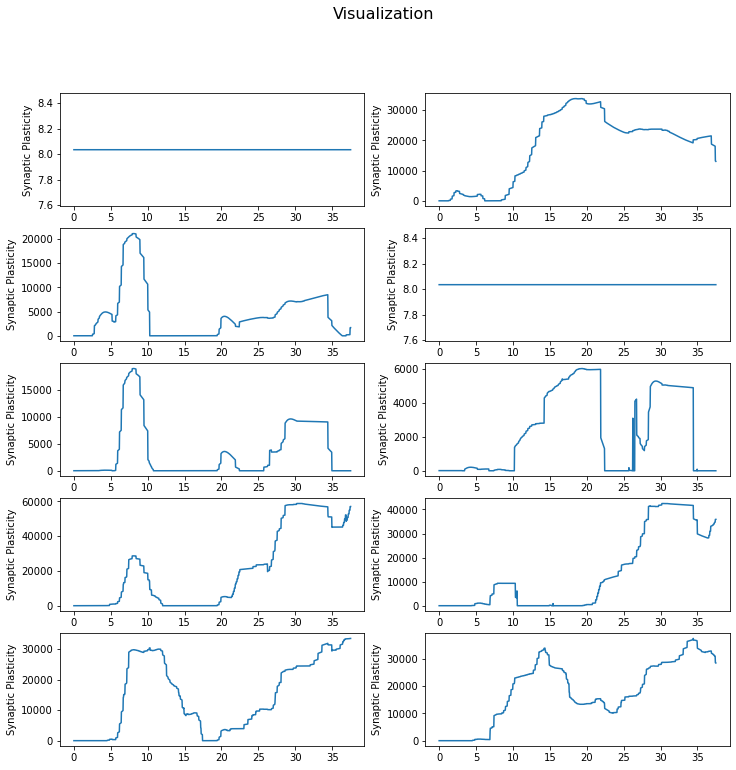

In [22]:
connections = neural_network.connection_history[0]
timelist = []
time = 0
dt = 0.03125
for i in range(len(connections)):
    timelist.append(time)
    time += dt
    
figure = plt.figure(figsize=(12,12))
figure.suptitle('Visualization',fontsize=16)

for i in range(5):
    for j in range(2):
        ax = plt.subplot2grid((5,2), (i,j))
        ax.plot(timelist,connections[:,2*i+j])
        ax.set_ylabel("Synaptic Plasticity")
plt.show()